In [ ]:
import numpy as np
from sklearn.datasets import load_digits, load_breast_cancer, fetch_olivetti_faces
from sklearn.model_selection import train_test_split, StratifiedKFold, LeaveOneOut
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
class NaiveBayesClassifier:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.mean = np.zeros((len(self.classes), X.shape[1]))
        self.var = np.zeros((len(self.classes), X.shape[1]))
        self.priors = np.zeros(len(self.classes))
        self.epsilon = 1e-9  # Pequeña constante para evitar división por cero

        for idx, c in enumerate(self.classes):
            X_c = X[y == c]
            self.mean[idx, :] = X_c.mean(axis=0)
            self.var[idx, :] = X_c.var(axis=0) + self.epsilon
            self.priors[idx] = X_c.shape[0] / X.shape[0]

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        posteriors = []

        for idx, c in enumerate(self.classes):
            prior = np.log(self.priors[idx])
            posterior = np.sum(np.log(self._pdf(idx, x) + self.epsilon))
            posterior = prior + posterior
            posteriors.append(posterior)

        return self.classes[np.argmax(posteriors)]

    def _pdf(self, class_idx, x):
        mean = self.mean[class_idx]
        var = self.var[class_idx]
        numerator = np.exp(- (x - mean) ** 2 / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator

In [ ]:
# Function to train and evaluate Naive Bayes classifier
def evaluate_naive_bayes(X, y, validation_method):
    model = NaiveBayesClassifier()
    labels = np.unique(y)  

    if validation_method == 'hold_out':
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred, labels=labels)
        return accuracy, conf_matrix

    elif validation_method == 'k_fold':
        skf = StratifiedKFold(n_splits=10)
        accuracies = []
        conf_matrices = []
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracies.append(accuracy_score(y_test, y_pred))
            conf_matrices.append(confusion_matrix(y_test, y_pred, labels=labels))
        mean_conf_matrix = np.mean(conf_matrices, axis=0)
        return np.mean(accuracies), mean_conf_matrix

    elif validation_method == 'leave_one_out':
        loo = LeaveOneOut()
        accuracies = []
        conf_matrices = []
        for train_index, test_index in loo.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracies.append(accuracy_score(y_test, y_pred))
            conf_matrices.append(confusion_matrix(y_test, y_pred, labels=labels))
        mean_conf_matrix = np.mean(conf_matrices, axis=0)
        return np.mean(accuracies), mean_conf_matrix

    else:
        raise ValueError("Invalid validation method")

# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, labels):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 10})
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


Results for digits dataset:
  Validation method: hold_out
    Accuracy: 0.7851851851851852
    Confusion Matrix:
[[53  0  0  0  1  0  0  0  0  0]
 [ 0 46  1  0  0  1  2  0  5  0]
 [ 0 10 29  0  0  0  0  0 14  0]
 [ 0  2  1 26  0  2  0  3 19  2]
 [ 0  4  0  0 41  0  2  6  1  0]
 [ 0  2  0  0  0 50  1  2  0  0]
 [ 0  1  0  0  0  0 53  0  0  0]
 [ 0  0  0  0  0  0  0 54  0  0]
 [ 0 12  0  0  0  0  0  1 39  0]
 [ 4  5  0  0  0  0  0  8  4 33]]



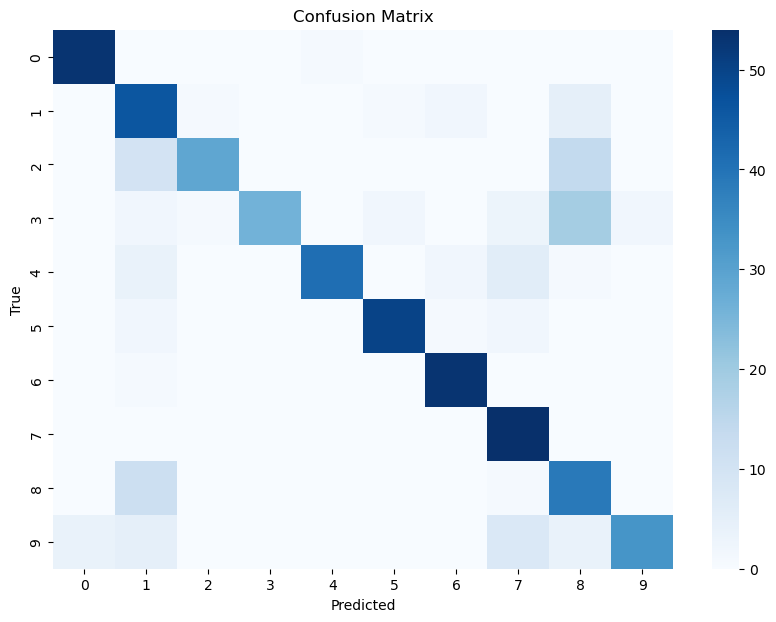

  Validation method: k_fold
    Accuracy: 0.7557169459962756
    Confusion Matrix:
[[17.7  0.   0.   0.   0.   0.   0.1  0.   0.   0. ]
 [ 0.  13.   0.1  0.   0.1  0.1  1.1  0.9  2.   0.9]
 [ 0.1  1.8  9.7  0.3  0.   0.2  0.1  0.1  5.4  0. ]
 [ 0.3  0.1  0.2 11.9  0.   0.8  0.5  1.1  3.2  0.2]
 [ 0.4  0.1  0.   0.  12.4  0.1  1.2  3.8  0.1  0. ]
 [ 0.2  0.2  0.   0.2  0.  16.   0.2  1.   0.3  0.1]
 [ 0.2  0.2  0.   0.   0.   0.1 17.6  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.1  0.   0.  17.8  0.   0. ]
 [ 0.   2.4  0.   0.   0.   0.8  0.   1.8 12.4  0. ]
 [ 3.8  1.   0.   0.7  0.1  0.6  0.   2.1  2.4  7.3]]



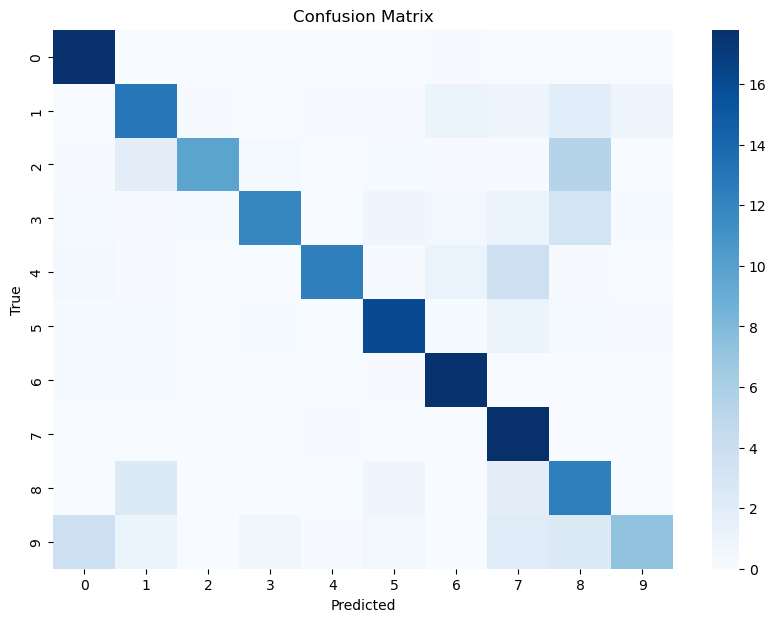

  Validation method: leave_one_out
    Accuracy: 0.798553144129104
    Confusion Matrix:
[[0.0984975  0.         0.         0.         0.         0.
  0.00055648 0.         0.         0.        ]
 [0.         0.07790762 0.         0.         0.         0.00055648
  0.0033389  0.00834725 0.00779076 0.0033389 ]
 [0.         0.00946021 0.05453534 0.         0.         0.00111297
  0.00055648 0.00055648 0.03171953 0.00055648]
 [0.00111297 0.00111297 0.00111297 0.07345576 0.         0.00389538
  0.00055648 0.00612131 0.01335559 0.00111297]
 [0.00055648 0.00055648 0.         0.         0.07289928 0.00111297
  0.00445186 0.02003339 0.00111297 0.        ]
 [0.         0.         0.         0.         0.         0.09404563
  0.00111297 0.00445186 0.00111297 0.00055648]
 [0.00111297 0.00111297 0.         0.         0.         0.00055648
  0.09794101 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.09961046 0.         0.        ]
 [0.   

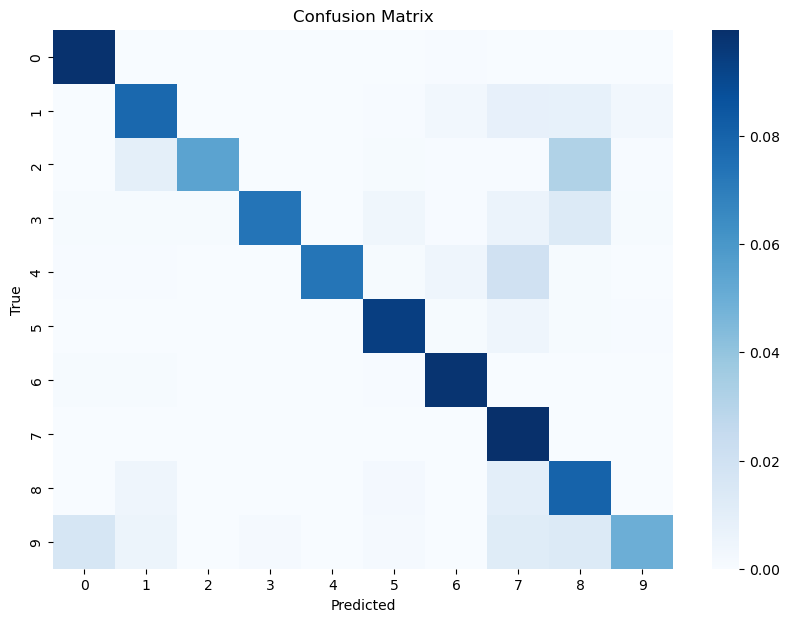

Results for breast_cancer dataset:
  Validation method: hold_out
    Accuracy: 0.935672514619883
    Confusion Matrix:
[[ 57   7]
 [  4 103]]



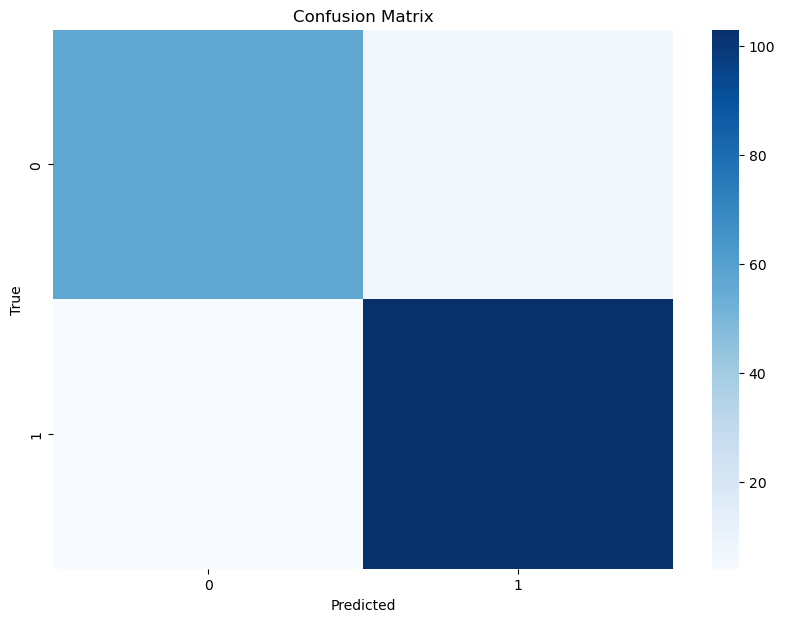

  Validation method: k_fold
    Accuracy: 0.9315162907268169
    Confusion Matrix:
[[19.1  2.1]
 [ 1.8 33.9]]



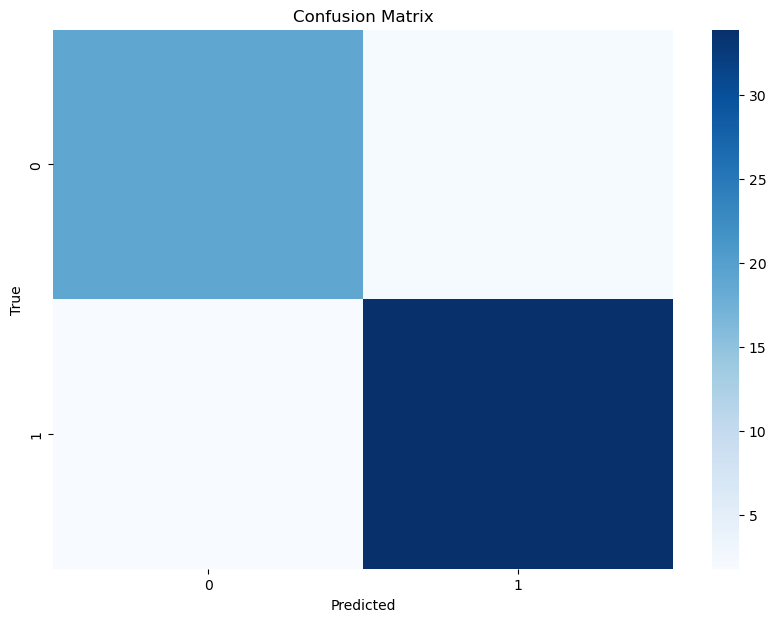

  Validation method: leave_one_out
    Accuracy: 0.9332161687170475
    Confusion Matrix:
[[0.33391916 0.03866432]
 [0.02811951 0.59929701]]



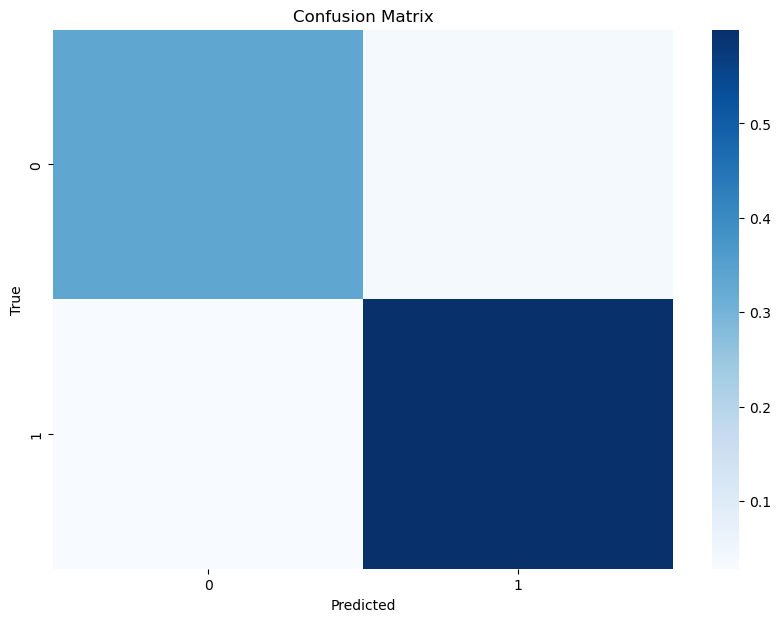

Results for olivetti_faces dataset:
  Validation method: hold_out
    Accuracy: 0.8833333333333333
    Confusion Matrix:
[[2 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 1]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 3]]



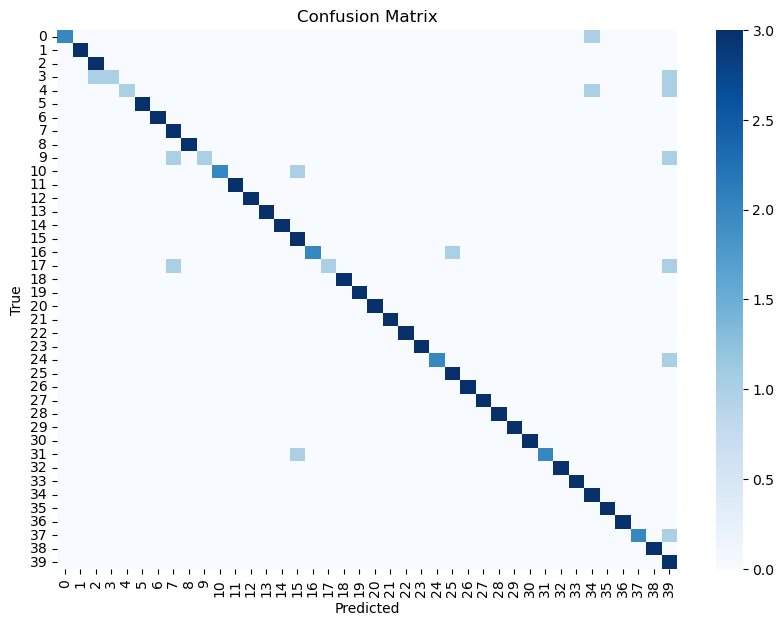

  Validation method: k_fold
    Accuracy: 0.9399999999999998
    Confusion Matrix:
[[0.9 0.  0.  ... 0.  0.  0. ]
 [0.  1.  0.  ... 0.  0.  0. ]
 [0.  0.  0.9 ... 0.  0.  0.1]
 ...
 [0.  0.  0.1 ... 0.8 0.  0.1]
 [0.  0.  0.  ... 0.  1.  0. ]
 [0.1 0.  0.  ... 0.  0.  0.9]]



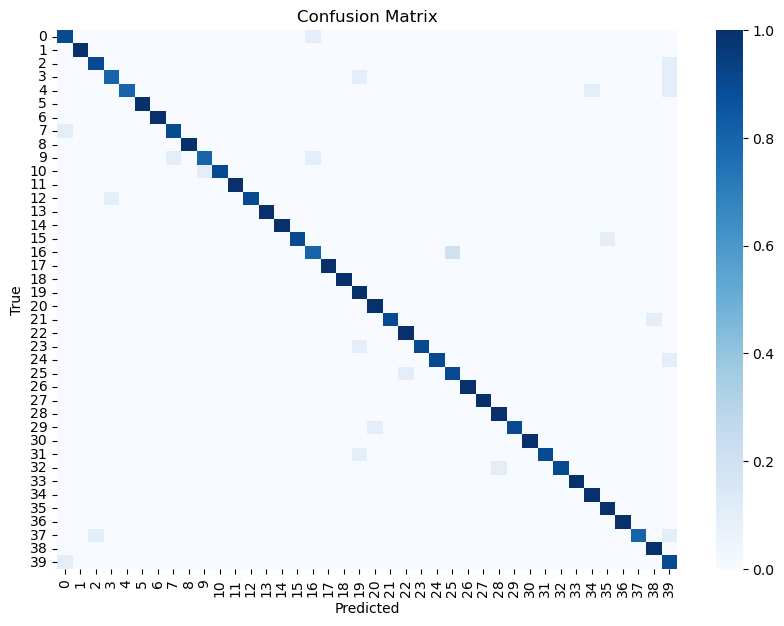

  Validation method: leave_one_out
    Accuracy: 0.93
    Confusion Matrix:
[[0.0225 0.     0.     ... 0.     0.     0.    ]
 [0.     0.025  0.     ... 0.     0.     0.    ]
 [0.     0.     0.0225 ... 0.     0.     0.0025]
 ...
 [0.     0.     0.     ... 0.02   0.     0.005 ]
 [0.     0.     0.     ... 0.     0.025  0.    ]
 [0.0025 0.     0.     ... 0.     0.     0.0225]]



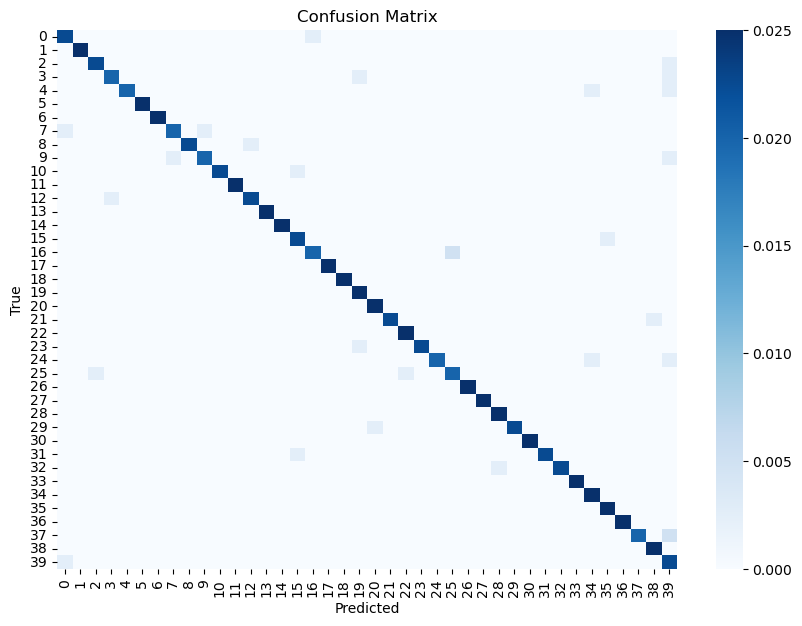

In [8]:
# Load datasets
datasets = {
    'digits': load_digits(),
    'breast_cancer': load_breast_cancer(),
    'olivetti_faces': fetch_olivetti_faces()
}

# Evaluate on each dataset with each validation method
results = {}
for name, dataset in datasets.items():
    X, y = dataset.data, dataset.target
    results[name] = {}
    for method in ['hold_out', 'k_fold', 'leave_one_out']:
        accuracy, conf_matrix = evaluate_naive_bayes(X, y, method)
        results[name][method] = {
            'accuracy': accuracy,
            'confusion_matrix': conf_matrix
        }

# Display results and plot confusion matrices
for dataset_name, methods in results.items():
    print(f"Results for {dataset_name} dataset:")
    for method, metrics in methods.items():
        print(f"  Validation method: {method}")
        print(f"    Accuracy: {metrics['accuracy']}")
        print(f"    Confusion Matrix:\n{metrics['confusion_matrix']}\n")
        plot_confusion_matrix(metrics['confusion_matrix'], np.unique(datasets[dataset_name].target))